In [ ]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import Adam
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
from torch.utils.data import Dataset
import os
import random
from PIL import Image

import torch.nn.functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [ ]:
transform_func = Compose([
    Resize(64),
    CenterCrop(64),
    ToTensor(),
    Normalize([0.5, 0.5, 0.5],
              [0.5, 0.5, 0.5])
])

In [ ]:
train_dataset = CelebA('data', split="train", download=True, transform=transform_func)

In [ ]:
test_dataset = CelebA('data', split="test", download=True, transform=transform_func)

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [ ]:
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [ ]:
train_dataset[0][0].shape

torch.Size([3, 64, 64])

In [ ]:
img_shape = train_dataset[0][0].shape

# Util

In [ ]:
def sample_images(generator, device):
    generator.eval()
    noise = torch.randn(1, 100).to(device)
    with torch.no_grad():
      gen_img = generator(noise)
    gen_img = gen_img * 0.5 + 0.5
    img = gen_img.squeeze(0).detach().cpu().permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [ ]:
def train(generator, discriminator, data_loader,
          optimizer_generator, optimizer_discriminator, criterion, device,
          latent_dim=100, epochs=5):

    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(data_loader):
          batch_size_curr = imgs.size(0)

          valid = torch.ones(batch_size_curr, 1).to(device)
          fake = torch.zeros(batch_size_curr, 1).to(device)

          real_imgs = imgs.to(device)

          optimizer_generator.zero_grad()

          z = torch.randn(batch_size_curr, latent_dim).to(device)

          gen_imgs = generator(z)

          g_loss = criterion(discriminator(gen_imgs), valid)

          g_loss.backward()
          optimizer_generator.step()

          optimizer_discriminator.zero_grad()

          real_loss = criterion(discriminator(real_imgs), valid)
          fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
          d_loss = 0.5 * (real_loss + fake_loss)
          d_loss.backward()
          optimizer_discriminator.step()

          print(f"Epoch {epoch + 1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

In [ ]:
import matplotlib.pyplot as plt

def visualize_generated_images(generator, device, latent_dim=100, n_images=10):
  generator.eval()
  noise = torch.randn(n_images, latent_dim).to(device)

  with torch.no_grad():
      gen_imgs = generator(noise)
  gen_imgs = gen_imgs * 0.5 + 0.5

  fig, axes = plt.subplots(1, 10, figsize=(15, 2))
  for i, ax in enumerate(axes):
      ax.imshow(gen_imgs[i].squeeze(0).detach().cpu().permute(1, 2, 0).numpy())
      ax.axis('off')
  plt.tight_layout()
  plt.show()

# Задача 1

In [ ]:
class Generator(nn.Module):
  def __init__(self, latent_dim=100):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
      nn.Linear(latent_dim, 512 * 4 * 4),
      nn.BatchNorm1d(512 * 4 * 4),
      nn.ReLU(True),
      nn.Unflatten(1, (512, 4, 4)),

      nn.ConvTranspose2d(512, 256, 4, 2, 1),
      nn.BatchNorm2d(256),
      nn.ReLU(True),

      nn.ConvTranspose2d(256, 128, 4, 2, 1),
      nn.BatchNorm2d(128),
      nn.ReLU(True),

      nn.ConvTranspose2d(128, 64, 4, 2, 1),
      nn.BatchNorm2d(64),
      nn.ReLU(True),

      nn.ConvTranspose2d(64, 3, 4, 2, 1),
      nn.Tanh()
      )

  def forward(self, noise):
    return self.model(noise)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
      nn.Conv2d(3, 64, 4, 2, 1),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(64, 128, 4, 2, 1),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(128, 256, 4, 2, 1),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Conv2d(256, 512, 4, 2, 1),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Flatten(),
      nn.Linear(512 * 4 * 4, 1),
      nn.Sigmoid()
      )

  def forward(self, img):
    return self.model(img)

In [ ]:
generator = Generator().to(device)

In [ ]:
discriminator = Discriminator().to(device)

In [ ]:
optimizer_generator = Adam(generator.parameters(), lr=0.0002)

In [ ]:
optimizer_discriminator = Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
criterion = nn.BCELoss()

In [ ]:
train(generator=generator,
      discriminator=discriminator,
      data_loader=train_loader,
      optimizer_generator=optimizer_generator,
      optimizer_discriminator=optimizer_discriminator,
      criterion=criterion,
      latent_dim=100,
      epochs=50,
      device=device)

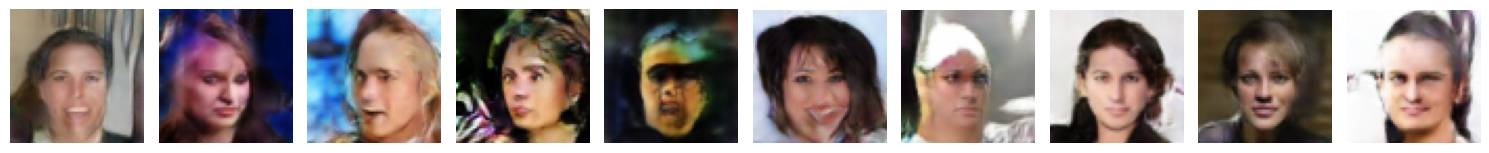

In [ ]:
visualize_generated_images(generator=generator, latent_dim=100, device=device, n_images=10)